In [16]:
# experiment0_mimo_quantization func
import numpy as np
import matplotlib.pyplot as plt
def generate_qam_symbols(M_order, Nsym):
    """
    生成 M-QAM 符号（平均功率归一化为 1）
    M_order: 例如 4, 16, 64
    """
    m = int(np.sqrt(M_order))
    assert m * m == M_order, "只支持方阵 QAM（4,16,64,256,...）"

    # 构造一维 PAM 星座：例如 16-QAM 对应 [-3, -1, 1, 3]
    pam = np.arange(-m + 1, m, 2)
    xv, yv = np.meshgrid(pam, pam)
    const_points = xv.flatten() + 1j * yv.flatten()

    # 平均功率归一化
    const_points = const_points / np.sqrt(np.mean(np.abs(const_points) ** 2))

    # 随机从星座中采样 Nsym 个符号
    idx = np.random.randint(0, M_order, size=Nsym)
    s = const_points[idx]
    return s


def uniform_midrise_quantizer(x, bits=1, clip=3.0):
    """
    对复数向量 x 的实部/虚部分别做中阶（mid-rise）均匀量化。
    bits: 量化比特数
    clip: 截断范围 [-clip, clip]，超过部分直接裁剪

    注意：
    - 这是一个通用 b-bit DAC 模型，不完全等同于论文里 1-bit 固定幅度的 sign 量化，
      但非常适合做“直观仿真”。
    """
    if bits < 1:
        raise ValueError("bits 必须 >= 1")

    # 每个实/虚分量的量化等级数
    L = 2 ** bits

    # 先裁剪
    xr = np.clip(x.real, -clip, clip)
    xi = np.clip(x.imag, -clip, clip)

    # 量化步长（mid-rise）：L 个重建值，L+1 个阈值
    # 例如 L=2 时，重建值在 [-Δ/2, Δ/2] 和 [Δ/2, 3Δ/2]
    delta = 2 * clip / L

    # 将 [-clip, clip] 映射到 [0, L-1] 的索引
    def quantize_real(v):
        # 移动到 [0, 2*clip]
        v_shift = v + clip
        idx = np.floor(v_shift / delta).astype(int)
        idx = np.clip(idx, 0, L - 1)
        # mid-rise 重建值：(-clip + delta/2) + idx * delta
        vq = -clip + delta / 2 + idx * delta
        return vq

    xr_q = quantize_real(xr)
    xi_q = quantize_real(xi)

    return xr_q + 1j * xi_q


def quantize_1bit_sign(x):
    """
    特殊的 1-bit 量化：sign 量化 + 固定幅度 1/sqrt(2)，
    更接近论文中的 1-bit DAC 模型。
    """
    return (np.sign(x.real) + 1j * np.sign(x.imag)) / np.sqrt(2)


def add_dither(x, sigma2=0.0):
    """
    对复数向量 x 加复高斯 dithering: CN(0, sigma2)
    """
    if sigma2 <= 0:
        return x
    std = np.sqrt(sigma2 / 2.0)
    d = std * (np.random.randn(*x.shape) + 1j * np.random.randn(*x.shape))
    return x + d

def nearest_constellation_point(r, const_points):
    """
    最近邻星座判决：
    r: 接收/均衡后的点（1D ndarray）
    const_points: 所有星座点（如 16-QAM 的 16 个点）
    返回硬判决符号
    """
    # r 的 shape: (Nsym,)
    # const_points shape: (M_order,)
    # 使用广播计算 |r - c|^2
    diff = r[:, None] - const_points[None, :]
    dist2 = np.abs(diff) ** 2
    idx_hat = np.argmin(dist2, axis=1)
    s_hat = const_points[idx_hat]
    return s_hat

def get_qam_constellation(M_order):
    """
    只生成 M-QAM 星座点表（平均功率归一化为 1），
    不抽样符号，用于最近邻判决。
    """
    m = int(np.sqrt(M_order))
    assert m * m == M_order, "只支持方阵 QAM（4,16,64,256,...）"

    pam = np.arange(-m + 1, m, 2)
    xv, yv = np.meshgrid(pam, pam)
    const_points = xv.flatten() + 1j * yv.flatten()
    const_points = const_points / np.sqrt(np.mean(np.abs(const_points) ** 2))
    return const_points

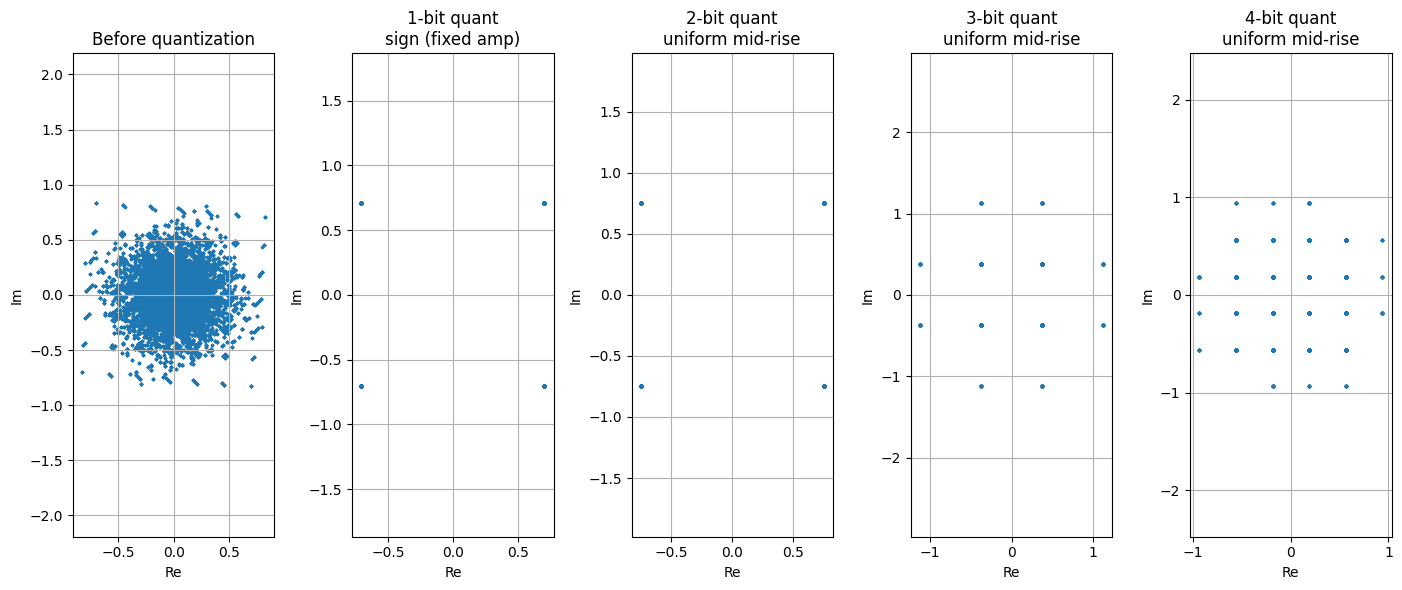

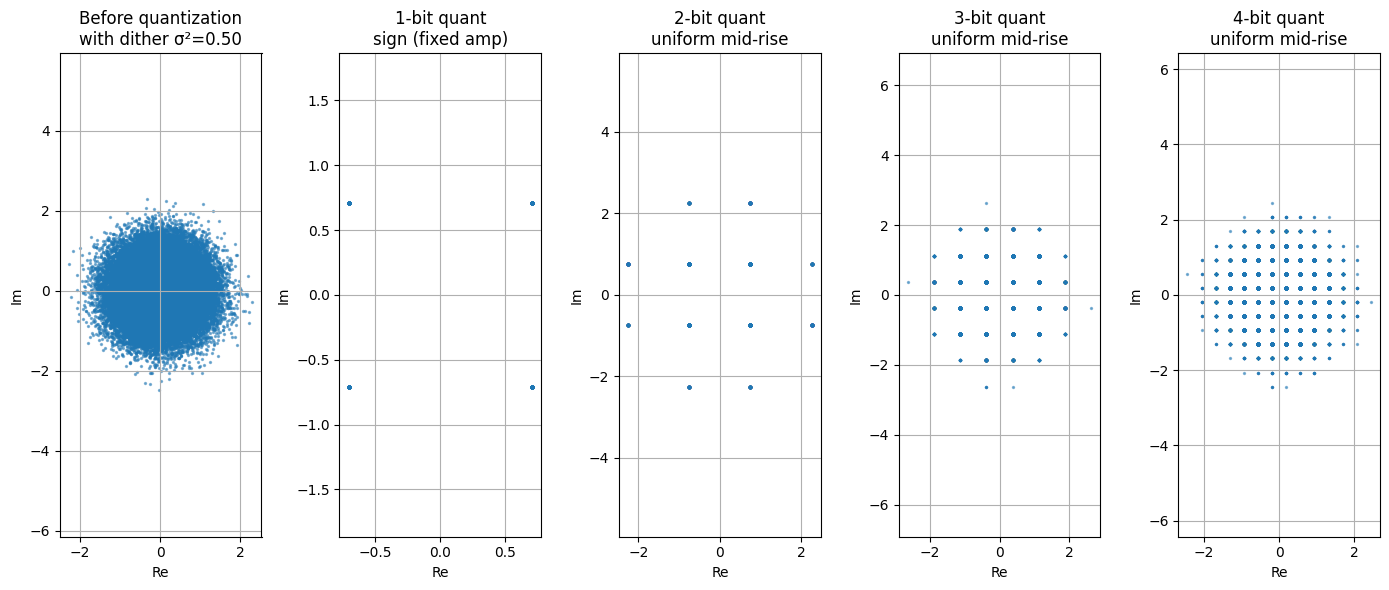

In [10]:
# ========= MIMO 实验主体 =========

def mimo_experiment_constellation(
    Nt=8,
    K=2,
    Nsym=2000,
    M_order=16,
    bits_list=(1, 2, 3, 4),
    use_sign_for_1bit=True,
    sigma2_dither=0.0,
    clip=3.0,
):
    """
    在 MIMO 场景下观察不同量化 bit 数 + dithering 对星座的影响。
    - Nt: 发射天线数
    - K: 数据流数
    - Nsym: 每条数据流的符号数
    - M_order: QAM 阶数（默认 16-QAM）
    - bits_list: 要比较的比特数列表，例如 (1,2,3,4)
    - use_sign_for_1bit: True 时，bits=1 用 sign 量化，其它 bits 用均匀量化
    - sigma2_dither: dithering 方差，0 表示不加 dithering
    - clip: 均匀量化的截断范围
    """

    # 1. 生成 K 路 QAM 符号（每条流 Nsym 个）
    S = np.zeros((K, Nsym), dtype=complex)
    for k in range(K):
        S[k, :] = generate_qam_symbols(M_order, Nsym)

    # 2. 构造随机预编码矩阵 W (Nt x K)，简单用 QR 得到近似正交列
    H_rand = (np.random.randn(Nt, K) + 1j * np.random.randn(Nt, K)) / np.sqrt(2)
    Q, _ = np.linalg.qr(H_rand)  # Nt x K
    W = Q  # 每列单位范数

    # 3. 发射信号 x = W @ S  (Nt x Nsym)
    X = W @ S

    # 扁平化为一维向量，用于画星座（把所有天线、所有符号都丢在一起）
    x_vec = X.flatten()

    # 如果要加 dithering，先在 x 上统一加
    x_dithered = add_dither(x_vec, sigma2=sigma2_dither)

    # 4. 画量化前星座
    plt.figure(figsize=(14, 6))
    plt.subplot(1, len(bits_list) + 1, 1)
    plt.scatter(x_dithered.real, x_dithered.imag, s=2, alpha=0.5)
    title = "Before quantization"
    if sigma2_dither > 0:
        title += f"\nwith dither σ²={sigma2_dither:.2f}"
    plt.title(title)
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.grid(True)
    plt.axis("equal")

    # 5. 对每个 bits 做量化并画星座
    for i, bits in enumerate(bits_list, start=2):
        if bits == 1 and use_sign_for_1bit:
            xq = quantize_1bit_sign(x_dithered)
            method = "sign (fixed amp)"
        else:
            xq = uniform_midrise_quantizer(x_dithered, bits=bits, clip=clip)
            method = "uniform mid-rise"

        plt.subplot(1, len(bits_list) + 1, i)
        plt.scatter(xq.real, xq.imag, s=2, alpha=0.5)
        plt.title(f"{bits}-bit quant\n{method}")
        plt.xlabel("Re")
        plt.ylabel("Im")
        plt.grid(True)
        plt.axis("equal")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    # ===== 实验参数 =====
    Nt = 16          # 发射天线数
    K = 2            # 数据流数
    Nsym = 4000      # 每条流的符号数
    M_order = 16     # 16-QAM
    bits_list = (1, 2, 3, 4)

    # 情况 1：不加 dithering，看不同 bit 的量化星座
    mimo_experiment_constellation(
        Nt=Nt,
        K=K,
        Nsym=Nsym,
        M_order=M_order,
        bits_list=bits_list,
        use_sign_for_1bit=True,
        sigma2_dither=0.0,
        clip=3.0,
    )

    # 情况 2：加一点 dithering，看星座“鼓起来”
    mimo_experiment_constellation(
        Nt=Nt,
        K=K,
        Nsym=Nsym,
        M_order=M_order,
        bits_list=bits_list,
        use_sign_for_1bit=True,
        sigma2_dither=0.5,  # 可以改成 0.1, 1.0 等试试看
        clip=3.0,
    )

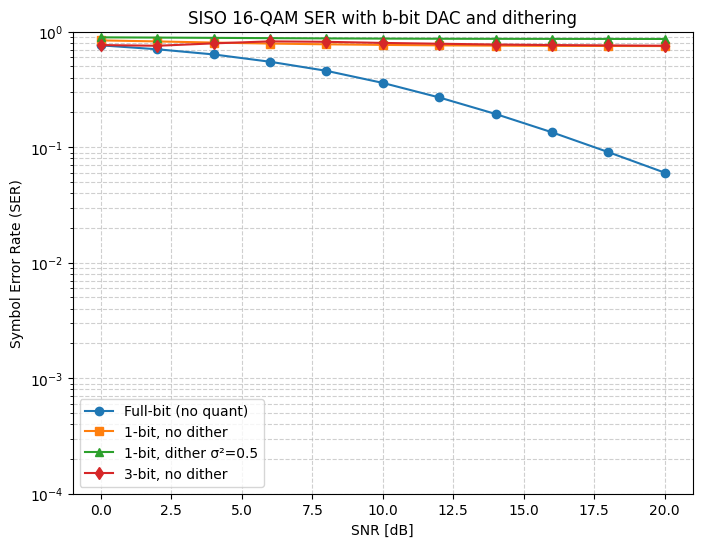

In [25]:
# ========= 实验1：SISO SER 仿真 =========

def simulate_ser_siso_bits(
    snr_db_list,
    Nsym=200000,
    M_order=16,
    bits=None,
    sigma2_dither=0.0,
    rayleigh_fading=True,
    use_sign_for_1bit=True,
    clip=3.0,
):
    """
    SISO 链路 SER 仿真（支持任意 bit 数量化）。

    参数：
    - bits = None : 不量化（full-bit baseline）
    - bits = 1    : 1-bit 量化；若 use_sign_for_1bit=True，则用 sign 量化，否则用均匀量化
    - bits >= 2   : 使用均匀 mid-rise 量化（uniform_midrise_quantizer）
    - sigma2_dither : dithering 方差（0 表示不加 dithering）
    """

    snr_db_list = np.array(snr_db_list)
    snr_linear_list = 10 ** (snr_db_list / 10.0)
    SER = []

    # --- 1. 生成符号和星座表 ---
    s = generate_qam_symbols(M_order, Nsym)
    const_points = get_qam_constellation(M_order)

    # --- 2. 信道 ---
    if rayleigh_fading:
        h = (np.random.randn(Nsym) + 1j * np.random.randn(Nsym)) / np.sqrt(2)
    else:
        h = np.ones(Nsym, dtype=complex)

    # --- 3. DAC 输入：可以加 dithering 再量化 ---
    x_in = s.copy()
    x_in = add_dither(x_in, sigma2=sigma2_dither)  # sigma2=0 时不改变

    # --- 4. 量化 ---
    if bits is None:
        # full-bit baseline：不量化
        x_tx = x_in
        quant_desc = "no quantization"
    else:
        if bits == 1 and use_sign_for_1bit:
            x_tx = quantize_1bit_sign(x_in)
            quant_desc = "1-bit sign"
        else:
            x_tx = uniform_midrise_quantizer(x_in, bits=bits, clip=clip)
            quant_desc = f"{bits}-bit uniform"

    # --- 5. 用统计量做 MMSE 一阶均衡 ---
    # 对任意量化模式，我们都估计 E[s x_tx*] 和 E[|x_tx|^2]
    E_s_xq = np.mean(s * np.conj(x_tx))
    E_xq2 = np.mean(np.abs(x_tx) ** 2)

    for rho in snr_linear_list:
        z = (np.random.randn(Nsym) + 1j * np.random.randn(Nsym)) / np.sqrt(2)
        y = np.sqrt(rho) * h * x_tx + z

        if bits is None:
            # baseline：理想均衡
            r = y / (np.sqrt(rho) * h)
        else:
            # 一阶 MMSE：
            # g = E[s x_tx*] h* / (rho * E[|x_tx|^2] |h|^2 + 1)
            g = (E_s_xq * np.conj(h)) / (rho * E_xq2 * np.abs(h) ** 2 + 1.0)
            r = g * y

        s_hat = nearest_constellation_point(r, const_points)
        SER.append(np.mean(s_hat != s))

    return SER


def run_experiment1_bits():
    snr_db_list = np.arange(0, 21, 2)
    Nsym = 200000
    M_order = 16

    # baseline：无量化
    ser_full = simulate_ser_siso_bits(
        snr_db_list,
        Nsym=Nsym,
        M_order=M_order,
        bits=None,          # 不量化
        sigma2_dither=0.0,
    )

    # 1-bit，无 dithering
    ser_1bit = simulate_ser_siso_bits(
        snr_db_list,
        Nsym=Nsym,
        M_order=M_order,
        bits=1,
        sigma2_dither=0.0,
        use_sign_for_1bit=True,
    )

    # 1-bit，有 dithering
    ser_1bit_d = simulate_ser_siso_bits(
        snr_db_list,
        Nsym=Nsym,
        M_order=M_order,
        bits=1,
        sigma2_dither=0.5,
        use_sign_for_1bit=True,
    )

    # 3-bit，无 dithering（示例）
    ser_3bit = simulate_ser_siso_bits(
        snr_db_list,
        Nsym=Nsym,
        M_order=M_order,
        bits=3,
        sigma2_dither=0.0,
        use_sign_for_1bit=False,   # bits>=2 用均匀量化，这里无所谓
    )

    plt.figure(figsize=(8, 6))
    plt.semilogy(snr_db_list, ser_full, "o-", label="Full-bit (no quant)")
    plt.semilogy(snr_db_list, ser_1bit, "s-", label="1-bit, no dither")
    plt.semilogy(snr_db_list, ser_1bit_d, "^-", label="1-bit, dither σ²=0.5")
    plt.semilogy(snr_db_list, ser_3bit, "d-", label="3-bit, no dither")

    plt.grid(True, which="both", ls="--", alpha=0.6)
    plt.xlabel("SNR [dB]")
    plt.ylabel("Symbol Error Rate (SER)")
    plt.title("SISO 16-QAM SER with b-bit DAC and dithering")
    plt.legend()
    plt.ylim(1e-4, 1)
    plt.show()


run_experiment1_bits()